# Introduction - Graded Challenge 7

Nama: Fauzan Rahmat Farghani

Batch: HCK-028

Objective:
Proyek ini bertujuan untuk membuat model Artificial Neural Network yang mampu mengklasifikasikan gambar ke dalam dua kategori, yaitu "Car" dan "Bike". Proses pengembangan model diawali dengan melakukan exploratory data analysis (EDA) untuk memahami karakteristik dan distribusi data yang tersedia. Selanjutnya, dilakukan feature engineering seperti image augmentation untuk meningkatkan kemampuan generalisasi model. Model kemudian dioptimasi melalui penyesuaian parameter. Evaluasi performa model dilakukan menggunakan metrik akurasi, f1-score, confusion matrix, dan classification report.

Problem Statement:
Model ini bertujuan untuk membantu sistem dalam mengklasifikasikan kendaraan sebagai mobil atau sepeda motor berdasarkan gambar. 

Link Dataset: https://www.kaggle.com/datasets/utkarshsaxenadn/car-vs-bike-classification-dataset

Pengguna: Pengelola sistem transportasi


# Import Libraries

Berikut adalah libraries yang digunakan di notebook:

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import sys
import sklearn as sk
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd

Pengecekan versi Tensor Flow dan kompatibilitas GPU:

In [2]:
print(f"Tensor Flow Version: {tf.__version__}")
#print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.18.0

Python 3.9.23 (main, Jun  5 2025, 08:49:36) 
[Clang 14.0.6 ]
Pandas 2.2.2
Scikit-Learn 1.6.1
GPU is available


# Data Loading

Bagian ini memuat data gambar dari folder menggunakan ImageDataGenerator, membagi data menjadi training dan validation, serta menampilkan jumlah data per kelas.

In [5]:
# Data Loading
base_dir = "Car-Bike-Dataset"

# Inisialisasi ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest',
    validation_split=0.2
)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Load training dan validation data langsung dari folder
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training',
    seed=42
)

val_generator = val_datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    seed=42
)

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Classes: {train_generator.class_indices}")

Found 3200 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Training samples: 3200
Validation samples: 800
Classes: {'Bike': 0, 'Car': 1}


Di bagian loading dataset, Class ImageDataGenerator melakukan proses sebagai berikut:

- Normalisasi: Membagi nilai piksel dengan 255 untuk menormalkan ke rentang [0, 1].

- Augmentasi data (hanya untuk data pelatihan): Rotasi, pergeseran lebar/tinggi, flip horizontal, zoom, dan shear untuk meningkatkan variasi data dan mencegah overfitting.

- Pembagian data: Dataset dibagi menjadi 80% data training dan 20% data validation.

- Target size: Semua gambar di-resize ke ukuran 224x224 piksel.

- Batch size: 32 gambar per batch.

- Class mode: binary untuk klasifikasi biner (Bike=0, Car=1).

Output:

Training samples: 3200 gambar
Validation samples: 800 gambar
Classes: {'Bike': 0, 'Car': 1}
Dataset memiliki total 4000 gambar, yang dibagi menjadi 3200 untuk pelatihan dan 800 untuk validasi.

In [6]:
# Menampilkan nama class
class_names = train_generator.class_indices
print("Class names:", list(class_names.keys()))

# Menampilkan contoh batch gambar dan label
images, labels = next(train_generator)
print("Batch image shape:", images.shape)
print("Batch label shape:", labels.shape)

Class names: ['Bike', 'Car']
Batch image shape: (32, 224, 224, 3)
Batch label shape: (32,)


Berikut rincian output:

- Mengambil satu batch data dari train_generator untuk memeriksa bentuk data gambar (images) dan label (labels).
- Bentuk batch gambar: (32, 224, 224, 3) menunjukkan 32 gambar dengan ukuran 224x224 piksel dan 3 channel warna (RGB).
- Bentuk batch label: (32,) menunjukkan 32 label biner (0 untuk Bike, 1 untuk Car).

In [7]:
#jumlah foto di file Bike
bike_count = len(os.listdir(os.path.join(base_dir, 'Bike')))
print(f"Jumlah foto di folder 'Bike': {bike_count}")

Jumlah foto di folder 'Bike': 2000


In [8]:
#jumlah foto di file Car
car_count = len(os.listdir(os.path.join(base_dir, 'Car')))
print(f"Jumlah foto di folder 'Car': {car_count}")

Jumlah foto di folder 'Car': 2000


Jumlah foto di 2 file Cars dan Bike masing-masing adalah 2000, menandakan data sudah balance.

# Exploratory Data Analysis

### 1. Sample Gambar Tiap Kelas 

In [9]:
def visualize_first_five_images(generator, class_names):
    images, labels = next(generator)
    plt.figure(figsize=(15, 6))
    shown = {name: 0 for name in class_names}
    max_per_class = 5
    total_needed = max_per_class * len(class_names)
    idx = 0
    for i in range(len(images)):
        class_idx = int(labels[i])
        class_name = class_names[class_idx]
        if shown[class_name] < max_per_class:
            plt.subplot(len(class_names), max_per_class, class_idx * max_per_class + shown[class_name] + 1)
            plt.imshow(images[i])
            plt.title(class_name)
            plt.axis("off")
            shown[class_name] += 1
            idx += 1
        if idx == total_needed:
            break
    plt.tight_layout()
    plt.show()

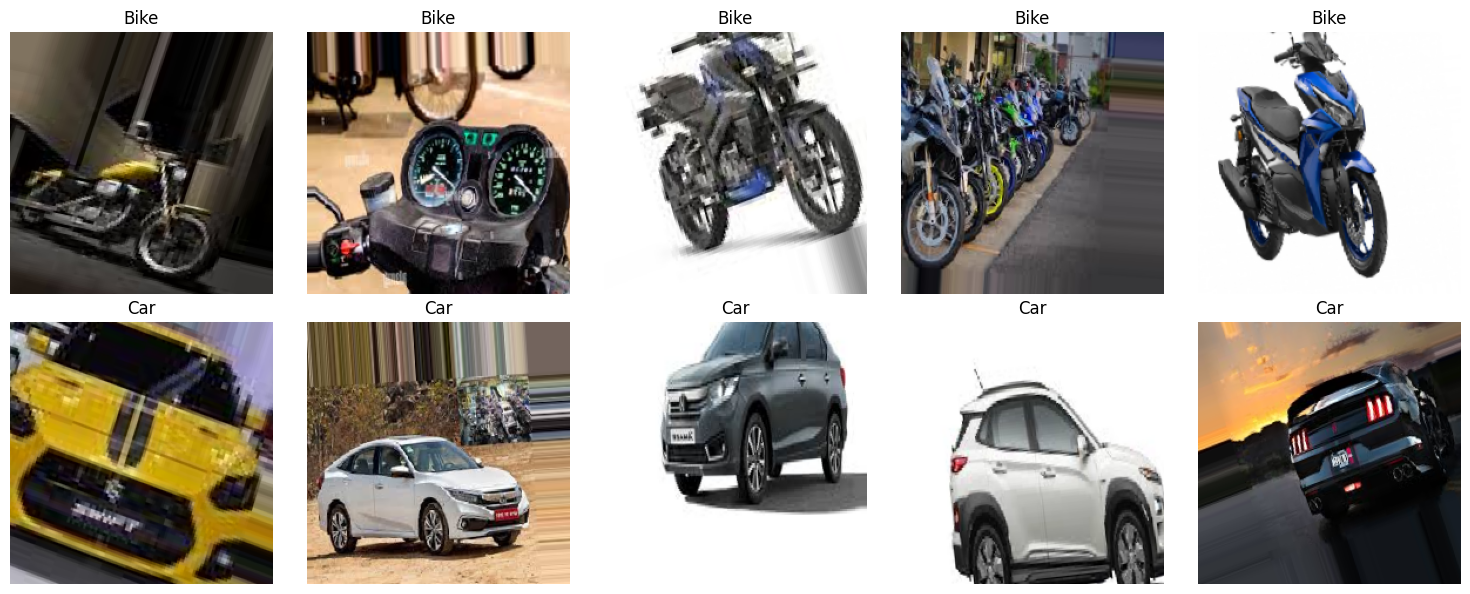

In [10]:
visualize_first_five_images(train_generator, list(train_generator.class_indices.keys()))

Visualisasi contoh gambar dari masing-masing kelas (Car dan Bike) diambil dari batch data training. Tujuannya untuk memastikan data yang digunakan sudah sesuai, gambar dapat terbaca dengan baik, serta distribusi kelas sudah sesuai. hal ini juga dapat membantu model mengenali karakteristik visual dari masing-masing kategori nantinya.

### 2. Ukuran Gambar dan Range Pixel

In [ ]:
images, labels = next(train_generator)
print("Contoh shape batch gambar:", images.shape)
print("Range pixel:", np.min(images), "-", np.max(images))

Contoh shape batch gambar: (32, 224, 224, 3)
Range pixel: 0.0 - 1.0


Pengecekan ukuran batch gambar dan range nilai pixel pada data training untuk memastikan gambar yang masuk ke model memiliki dimensi yang sesuai. Hal ini juga dapat memastikan tidak ada data error pada gambar yang bisa mengganggu proses training model.

Rincian Penjelasan:

- Bentuk batch gambar: (32, 224, 224, 3) menunjukkan 32 gambar dengan ukuran 224x224 piksel dan 3 channel warna (RGB).

### 3. Sample Gambar untuk Validation

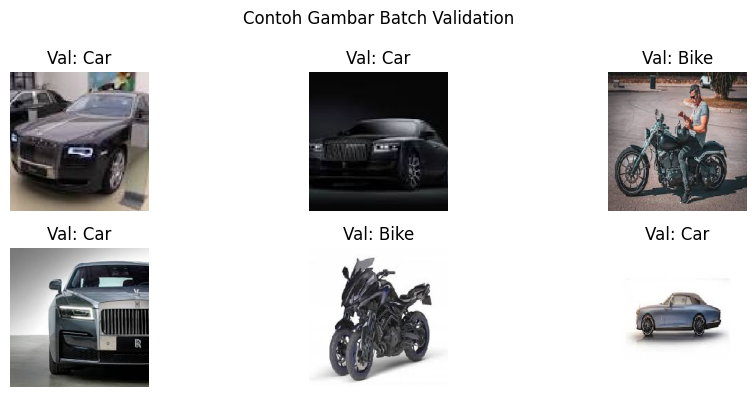

In [ ]:
train_counts = np.bincount(train_generator.classes.astype(int))
val_counts = np.bincount(val_generator.classes.astype(int))
class_map = {v: k for k, v in train_generator.class_indices.items()}

images_val, labels_val = next(val_generator)
plt.figure(figsize=(10,4))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(images_val[i])
    plt.title(f"Val: {class_map[int(labels_val[i])]}")
    plt.axis('off')
plt.suptitle('Contoh Gambar Batch Validation')
plt.tight_layout()
plt.show()

Berikut adalah sampel gambar yang digunakan untuk uji validasi dari dataset. Visualisasi sampel gambar dari data validation bertujuan untuk memastikan bahwa data validasi yang digunakan dalam proses evaluasi model sudah benar dan representatif. Dengan menampilkan beberapa gambar beserta label aslinya, kita dapat memverifikasi bahwa gambar-gambar tersebut telah terpisah dari data training dan labelnya sesuai.


### 4. Distribusi Data Train & Validation per Kelas

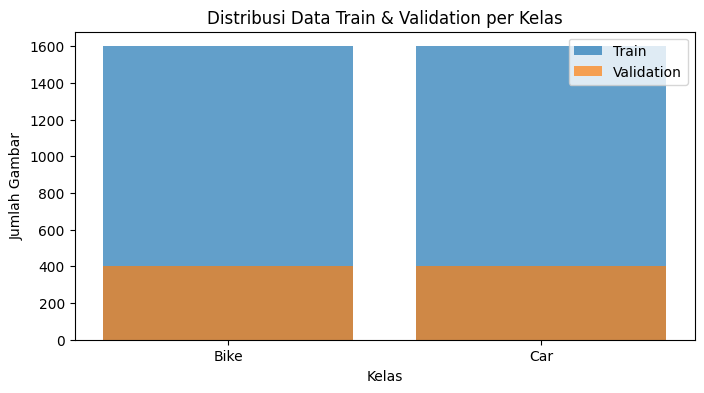

In [13]:
plt.figure(figsize=(8,4))
plt.bar([class_map[i] for i in range(len(train_counts))], train_counts, alpha=0.7, label='Train')
plt.bar([class_map[i] for i in range(len(val_counts))], val_counts, alpha=0.7, label='Validation')
plt.title('Distribusi Data Train & Validation per Kelas')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Gambar')
plt.legend()
plt.show()

Seperti yang sudah dijelaskan di data loading terkait proporsi train dan validation, berikut adalah visualisasi untuk menunjukkan bahwa data sudah seimbang dan terbagi berdasarkan porsi 80% Train dan 20% Validation.

# Feature Engineering

### 1. Image Augmentation

In [ ]:
train_datagen_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Reload training data with augmentation
train_generator_aug = train_datagen_aug.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training',
    seed=42
)

# Validation data remains without augmentation (jika ingin cek range pixel, juga tanpa rescale)
val_generator_norescale = train_datagen_aug.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    seed=42
)

# Cek range pixel batch hasil augmentasi
images_aug, labels_aug = next(train_generator_aug)
print("Contoh shape batch gambar (augmentasi):", images_aug.shape)
print("Range pixel (augmentasi):", np.min(images_aug), "-", np.max(images_aug))

Found 3200 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Contoh shape batch gambar (augmentasi): (32, 224, 224, 3)
Range pixel (augmentasi): 0.0 - 255.0


Pada bagian ini dilakukan proses augmentasi gambar pada data training menggunakan `ImageDataGenerator`. Augmentasi yang digunakan meliputi rotasi, pergeseran, shear, zoom, perubahan brightness, dan flipping secara horizontal. Setelah itu, dilakukan pengecekan shape dan range pixel dari batch gambar hasil augmentasi untuk memastikan proses augmentasi berjalan dengan baik dan data siap digunakan untuk training.

## 2. Visualisasi gambar hasil augmentasi

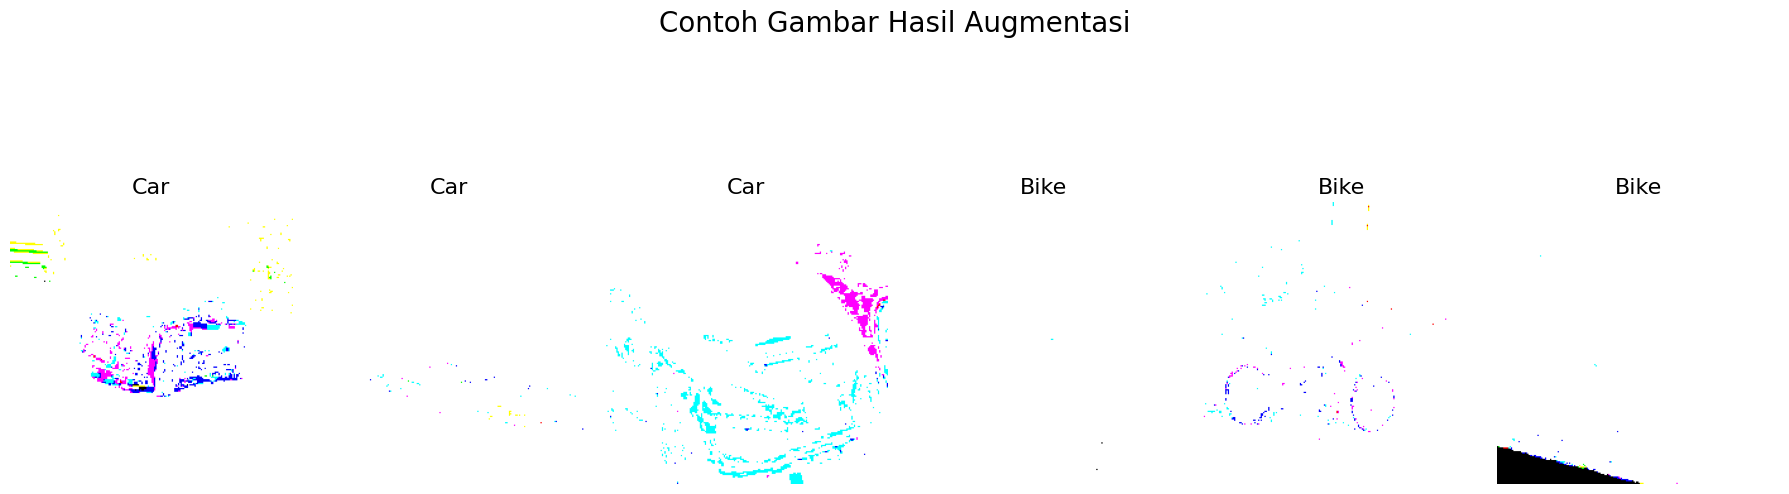

In [ ]:
num_per_class = 3  # tampilkan 3 gambar Bike dan 3 gambar Car
class_indices = {v: k for k, v in train_generator.class_indices.items()}
shown = {0: 0, 1: 0}
selected_imgs = []
selected_labels = []

# Ambil gambar augmentasi secara seimbang per kelas
for idx in range(len(images_aug)):
    label = int(labels_aug[idx])
    if shown[label] < num_per_class:
        selected_imgs.append(images_aug[idx])
        selected_labels.append(class_indices[label])
        shown[label] += 1
    if sum(shown.values()) == 2 * num_per_class:
        break

plt.figure(figsize=(18, 6))  # lebih lebar dan besar
for i, (img, label) in enumerate(zip(selected_imgs, selected_labels)):
    plt.subplot(1, 6, i+1)
    plt.imshow(img)
    plt.title(f"{label}", fontsize=16)
    plt.axis('off')
plt.suptitle('Contoh Gambar Hasil Augmentasi', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()

Kode berikut digunakan untuk menampilkan contoh gambar hasil augmentasi dari masing-masing kelas. Sebanyak 3 gambar dari kelas Bike dan 3 gambar dari kelas Car diambil dari batch hasil augmentasi, kemudian divisualisasikan dalam satu baris. Hasil dari visualisasi masih menunjukkan hasil yang tidak optimal.

# ANN Training

#### Model Definition

In [16]:
# ANN Training - Model Definition (Sequential API)
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

/opt/anaconda3/envs/h8_env/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-07-01 14:55:09.850667: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-07-01 14:55:09.850854: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-07-01 14:55:09.850861: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
I0000 00:00:1751356509.851495  494631 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1751356509.851714  494631 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 wit

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

Kernel size (3,3) pada convolutional layer dipilih karena ukuran ini efektif untuk mengekstraksi fitur lokal dari gambar tanpa kehilangan terlalu banyak informasi. Pool size (2,2) pada pooling layer digunakan untuk mereduksi dimensi feature map secara efisien, mempercepat proses komputasi, dan membantu mencegah overfitting.

**Justifikasi Activation Function**: 
Pada hidden layer digunakan fungsi aktivasi ReLU karena dapat mengatasi masalah vanishing gradient dan mempercepat proses training. Pada output layer digunakan sigmoid karena model melakukan klasifikasi biner, sehingga output berupa probabilitas antara 0 dan 1.

**Justifikasi Jumlah Neuron**: Output layer hanya menggunakan 1 neuron karena tugas klasifikasi ini bersifat biner (Bike atau Car). Output 1 neuron dengan sigmoid akan menghasilkan probabilitas yang dapat langsung dipetakan ke dua kelas.

**Justifikasi Loss Function**: Loss function yang digunakan adalah binary_crossentropy karena sesuai untuk kasus klasifikasi biner. Fungsi ini mengukur perbedaan antara label sebenarnya (0 atau 1) dan probabilitas prediksi model.

#### Model Training

In [ ]:
# Model Training
history = model.fit(
    train_generator_aug,
    epochs=100,
    validation_data=val_generator,
    verbose=1
)

/opt/anaconda3/envs/h8_env/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


2025-07-01 14:55:11.081692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


 13/100 ━━━━━━━━━━━━━━━━━━━━ 18s 213ms/step - accuracy: 0.4815 - loss: 1620.4576

/opt/anaconda3/envs/h8_env/lib/python3.9/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 211ms/step - accuracy: 0.4999 - loss: 559.5889 - val_accuracy: 0.4375 - val_loss: 0.7249
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 192ms/step - accuracy: 0.4703 - loss: 78.1331 - val_accuracy: 0.5100 - val_loss: 0.6926
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 187ms/step - accuracy: 0.5170 - loss: 62.5645 - val_accuracy: 0.5038 - val_loss: 2.4265
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 188ms/step - accuracy: 0.5093 - loss: 206.8727 - val_accuracy: 0.5850 - val_loss: 0.8399
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 187ms/step - accuracy: 0.5346 - loss: 156.7576 - val_accuracy: 0.5213 - val_loss: 2.9198
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 194ms/step - accuracy: 0.6020 - loss: 110.7311 - val_accuracy: 0.5288 - val_loss: 3.9582
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 217ms/step - accuracy: 0.6518 - loss: 75.0908 - val_accuracy: 0.5763 - val_loss: 3.5950
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 214ms/step - accuracy: 0.7044 - loss: 7

#### Model Evaluation

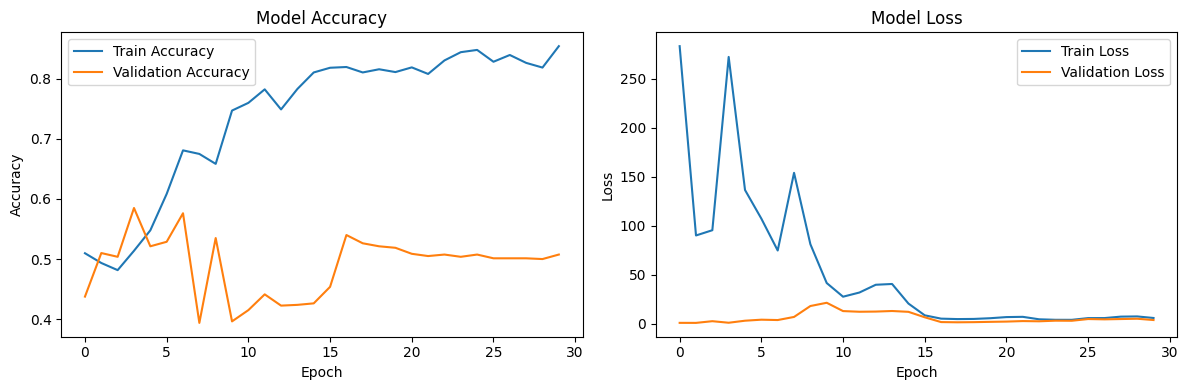

In [18]:
# Plot training & validation accuracy/loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

Grafik pertama menunjukkan perkembangan akurasi pada data training dan validation di setiap epoch, sedangkan grafik kedua menunjukkan perkembangan nilai loss. Visualisasi ini untuk memantau apakah model mengalami overfitting (selisih akurasi/loss yang besar antara training dan validation) atau underfitting (akurasi rendah pada keduanya). Berikut kesimpulan terkait hasil visualisasi:

- Tren Akurasi Pelatihan (Train Accuracy): Garis akurasi pelatihan meningkat seiring epoch, menunjukkan bahwa model belajar dengan baik pada data pelatihan.

- Tren Akurasi Validasi (Validation Accuracy): Akurasi validasi menurun sementara akurasi pelatihan terus meningkat, hal ini berpotensi mengindikasikan overfitting, di mana model terlalu menyesuaikan diri dengan data pelatihan dan gagal menggeneralisasi pada data baru.

- Train Loss (biru) menurun tajam dari 250 ke sekitar 50 pada epoch awal, lalu stabil dengan sedikit fluktuasi, menunjukkan model berhasil mengurangi kesalahan pada data pelatihan.

- Validation Loss (oranye) juga menurun pada epoch awal, tetapi kemudian meningkat dan stabil di kisaran rendah (sekitar 0-20) setelah epoch 10, menunjukkan bahwa kesalahan pada data validasi tidak konsisten dengan tren pelatihan.

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


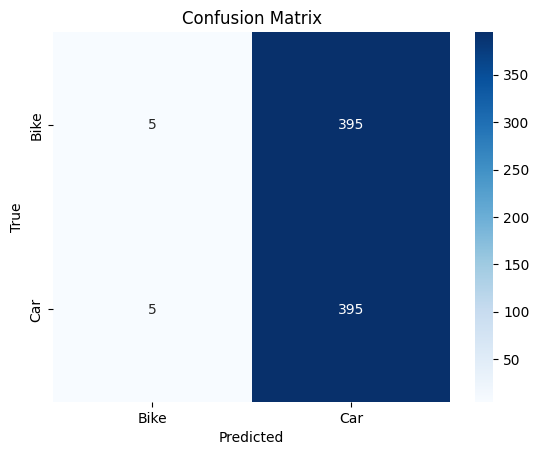

{'Bike': 0, 'Car': 1}
              precision    recall  f1-score   support

        Bike       0.50      0.01      0.02       400
         Car       0.50      0.99      0.66       400

    accuracy                           0.50       800
   macro avg       0.50      0.50      0.34       800
weighted avg       0.50      0.50      0.34       800



In [20]:
# Confusion Matrix and Classification Report
val_pred = (model.predict(val_generator) > 0.5).astype(int)
val_true = val_generator.classes
cm = confusion_matrix(val_true, val_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Bike', 'Car'], yticklabels=['Bike', 'Car'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(val_generator.class_indices)
print(classification_report(val_true, val_pred, target_names=['Bike', 'Car']))

Berdasarkan confusion matrix dan classification report yang diberikan, berikut adalah kesimpulan dari hasil visualisasi:

Confusion Matrix:
- True Bike, Predicted Bike: 5 (hanya 5 instance benar-benar diklasifikasikan sebagai Bike).
- True Bike, Predicted Car: 395 (sebagian besar instance Bike salah diprediksi sebagai Car).
- True Car, Predicted Bike: 5 (hanya 5 instance Car salah diprediksi sebagai Bike).
- True Car, Predicted Car: 395 (sebagian besar instance Car benar diprediksi sebagai Car).

Classification Report:

Bike:
- Precision: 0.50 (50% dari prediksi Bike benar).
- Recall: 0.01 (hanya 1% instance Bike yang sebenarnya berhasil terdeteksi).
- F1-Score: 0.02 (skor harmonik yang sangat rendah, menunjukkan performa buruk untuk kelas Bike).
- Support: 400 (jumlah instance Bike).

Car:
- Precision: 0.50 (50% dari prediksi Car benar).
- Recall: 0.99 (99% instance Car yang sebenarnya berhasil terdeteksi).
- F1-Score: 0.66 (skor yang cukup baik untuk kelas Car).
- Support: 400 (jumlah instance Car).
- Accuracy: 0.50 (50% prediksi keseluruhan benar).

berdasarkan kesimpulan tersebut, model pertama bersifat bias dan tidak seimbang dengan akurasi yang rendah.

# ANN Improvement

#### Model Definition

Pada model improvement, dilakukan penambahan batch normalization untuk menstabilkan dan mempercepat proses training, serta dropout untuk mengurangi overfitting. Selain itu, jumlah neuron pada dense layer ditingkatkan dan arsitektur CNN diperdalam agar model dapat mengekstraksi fitur lebih kompleks dari gambar.

In [21]:
# Define Improved CNN Model

model_improved = models.Sequential([
    # Convolutional Block 1
    layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same', activation='relu', input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2), strides=(2, 2)),
    
    # Convolutional Block 2
    layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2), strides=(2, 2)),
    
    # Convolutional Block 3
    layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2), strides=(2, 2)),
    
    # Flatten and Dense Layers
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Single neuron for binary classification
])

# Compile the Model
model_improved.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Model Summary
model_improved.summary()

/opt/anaconda3/envs/h8_env/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,784,769 (98.36 MB)

 Trainable params: 25,784,321 (98.36 MB)

 Non-trainable params: 448 (1.75 KB)

Pada improvement, kernel size tetap (3,3) dan pool size (2,2) dipertahankan karena sudah terbukti efektif. Padding 'same' digunakan agar dimensi feature map tetap terjaga, dan strides pada pooling layer diatur untuk mempercepat reduksi dimensi. Penambahan batch normalization dan dropout juga bertujuan untuk meningkatkan generalisasi model.

#### Model Training

In [ ]:
# Model Training
history_improved = model_improved.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    verbose=1
)

/opt/anaconda3/envs/h8_env/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
 12/100 ━━━━━━━━━━━━━━━━━━━━ 26s 304ms/step - accuracy: 0.5523 - loss: 34.9042

/opt/anaconda3/envs/h8_env/lib/python3.9/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


100/100 ━━━━━━━━━━━━━━━━━━━━ 32s 295ms/step - accuracy: 0.5920 - loss: 38.9625 - val_accuracy: 0.5250 - val_loss: 8.9851
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 30s 298ms/step - accuracy: 0.7027 - loss: 32.3503 - val_accuracy: 0.5375 - val_loss: 27.0945
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 38s 381ms/step - accuracy: 0.7695 - loss: 24.9533 - val_accuracy: 0.5250 - val_loss: 47.6812
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 32s 321ms/step - accuracy: 0.7597 - loss: 24.0805 - val_accuracy: 0.5013 - val_loss: 60.0465
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 310ms/step - accuracy: 0.7920 - loss: 17.5242 - val_accuracy: 0.8138 - val_loss: 6.4158
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 303ms/step - accuracy: 0.8040 - loss: 13.3999 - val_accuracy: 0.8637 - val_loss: 4.2497
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 309ms/step - accuracy: 0.8061 - loss: 8.2717 - val_accuracy: 0.8988 - val_loss: 2.0981
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 44s 435ms/step - accuracy: 0.8072 - loss: 5.7

#### Model Evaluation

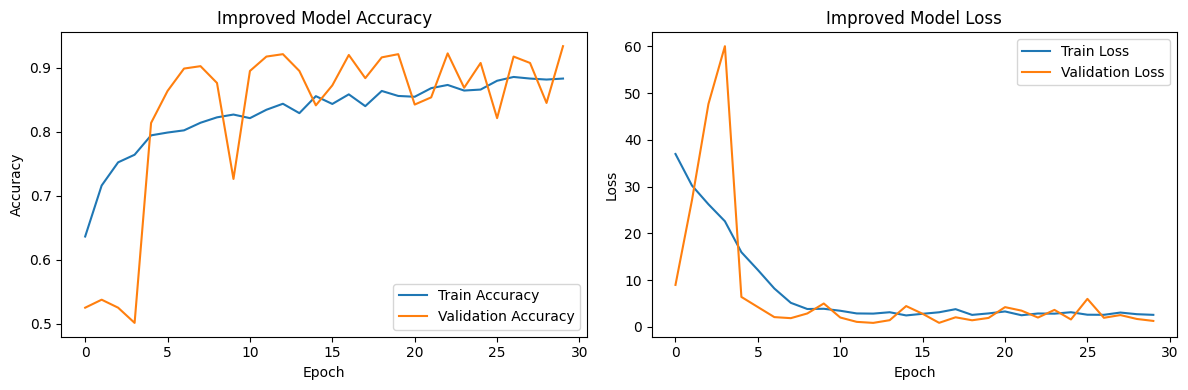

In [23]:
# Model Evaluation
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_improved.history['accuracy'], label='Train Accuracy')
plt.plot(history_improved.history['val_accuracy'], label='Validation Accuracy')
plt.title('Improved Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_improved.history['loss'], label='Train Loss')
plt.plot(history_improved.history['val_loss'], label='Validation Loss')
plt.title('Improved Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

Improved Model Accuracy (Grafik Kiri):
- Train Accuracy (biru) meningkat dari sekitar 0.6 ke 0.9 pada epoch awal, lalu stabil dengan fluktuasi kecil di kisaran 0.85-0.9 setelah epoch 10.
- Validation Accuracy (oranye) juga meningkat tajam dari 0.5 ke sekitar 0.9 pada epoch awal (sekitar 5-10), lalu menunjukkan fluktuasi di kisaran 0.85-0.9, dengan sedikit tren menurun setelah epoch 20.
- Kedua garis menunjukkan tren yang serupa, dengan akurasi validasi mendekati akurasi pelatihan, menunjukkan konsistensi performa.

Improved Model Loss (Grafik Kanan):
- Train Loss (biru) menurun tajam dari 60 ke sekitar 5-10 pada epoch awal, lalu stabil dengan fluktuasi kecil di kisaran rendah.
- Validation Loss (oranye) juga menurun tajam dari 60 ke sekitar 0-10 pada epoch awal, dengan sedikit kenaikan setelah epoch 20, tetapi tetap pada level rendah.
- Kedua loss menunjukkan konvergensi yang baik setelah epoch awal, dengan validasi loss sedikit lebih tinggi dari train loss pada epoch akhir.

In [24]:
# Evaluate on validation set
val_loss_imp, val_accuracy_imp = model_improved.evaluate(val_generator)
print(f"Improved Validation Loss: {val_loss_imp:.4f}")
print(f"Improved Validation Accuracy: {val_accuracy_imp:.4f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9509 - loss: 0.8928
Improved Validation Loss: 1.2834
Improved Validation Accuracy: 0.9337


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


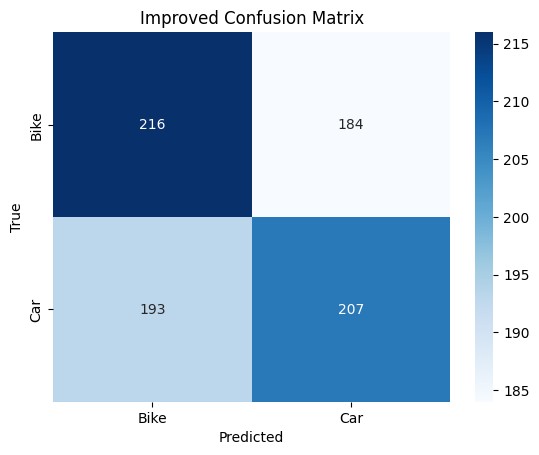

              precision    recall  f1-score   support

        Bike       0.53      0.54      0.53       400
         Car       0.53      0.52      0.52       400

    accuracy                           0.53       800
   macro avg       0.53      0.53      0.53       800
weighted avg       0.53      0.53      0.53       800



In [25]:
# Confusion Matrix and Classification Report
val_pred_imp = (model_improved.predict(val_generator) > 0.5).astype(int)
cm_imp = confusion_matrix(val_true, val_pred_imp)
sns.heatmap(cm_imp, annot=True, fmt='d', cmap='Blues', xticklabels=['Bike', 'Car'], yticklabels=['Bike', 'Car'])
plt.title('Improved Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(classification_report(val_true, val_pred_imp, target_names=['Bike', 'Car']))

Model memprediksi kelas pada data validasi (val_generator) dan mengubah probabilitas menjadi label biner (0 untuk Bike, 1 untuk Car) dengan threshold 0.5. Pemilihan threshold 0.5 pada prediksi model dilakukan karena model menggunakan fungsi aktivasi sigmoid pada output layer, sehingga menghasilkan probabilitas antara 0 dan 1. Threshold 0.5 adalah nilai standar untuk klasifikasi biner, di mana probabilitas di atas 0.5 dikategorikan sebagai kelas 1 (Car) dan di bawah atau sama dengan 0.5 sebagai kelas 0 (Bike). Threshold ini dipilih karena dataset sudah seimbang dan tidak ada preferensi khusus terhadap salah satu kelas.

Confusion Matrix divisualisasikan untuk menunjukkan jumlah prediksi benar dan salah per kelas. Dari visualisasi, angkanya sudah meningkat dibanding model sebelumnya karena sebelumnya matrix lebih dominan ke mobil (nilai confusion matrix untuk Bike adalah 0).

Classification Report berguna untuk menampilkan metrik evaluasi seperti precision, recall, dan F1-score untuk setiap kelas, serta akurasi keseluruhan. Berikut ringkasannya:

- Precision: 0.53 untuk kedua kelas, menunjukkan bahwa 53% prediksi untuk setiap kelas benar.
- Recall: 0.54 untuk Bike dan 0.52 untuk Car, menunjukkan proporsi data.
- F1-score: 0.53 untuk Bike dan 0.52 untuk Car, rata-rata dari precision dan recall.
- Akurasi: 0.53, yang menunjukkan bahwa model hanya benar dalam 53% kasus, hampir setara dengan random guessing untuk klasifikasi biner.

# Model Saving

In [26]:
# Model Saving
model_improved.save('car_bike_classifier.h5')

# Conclusion

Proyek ini berhasil melakukan EDA pada dataset Car vs Bike Classification, menunjukkan bahwa dataset seimbang dan memiliki variasi visual yang cukup. Namun, performa model (model_improved) sangat rendah (akurasi 53%), yang menunjukkan bahwa model tidak dapat digunakan untuk aplikasi dalam pengelolaan sistem transportasi. Penyebab potensial termasuk arsitektur model yang kurang optimal, pelatihan yang tidak memadai, atau kompleksitas dataset yang memerlukan pendekatan lebih canggih seperti transfer learning. Rekomendasi untuk model mencakup penggunaan arsitektur CNN yang lebih kuat, tuning hyperparameter, dan augmentasi data tambahan. Dari sisi bisnis, model perlu ditingkatkan secara signifikan sebelum dapat diimplementasikan dalam sistem transportasi untuk otomatisasi identifikasi kendaraan. Dengan peningkatan ini, model berpotensi meningkatkan efisiensi operasional dan mendukung pengambilan keputusan berbasis data dalam pengelolaan transportasi.

Berdasarkan analisis dan hasil yang ditunjukkan dalam notebook:

- Dataset: Dataset terdiri dari 4000 gambar yang seimbang (2000 gambar untuk kelas Bike dan 2000 untuk kelas Car), dibagi menjadi 3200 untuk pelatihan dan 800 untuk validasi. Keseimbangan ini memastikan model tidak bias terhadap salah satu kelas.
- EDA: Visualisasi sampel gambar menunjukkan bahwa dataset memiliki variasi visual yang didukung oleh augmentasi data (rotasi, flip, zoom, dll.) untuk meningkatkan generalisasi model.
- Performa Model: model_improved hanya mencapai akurasi 53%, dengan precision, recall, dan F1-score yang hampir seragam di sekitar 0.53 untuk kedua kelas. Ini menunjukkan bahwa model tidak berhasil mempelajari pola yang cukup untuk membedakan Bike dan Car, hampir setara dengan tebakan acak.
- Evaluasi: Confusion matrix dan classification report menunjukkan bahwa model memiliki tingkat kesalahan yang tinggi.

Kendala: 

Performa model yang rendah (akurasi 53%) menunjukkan bahwa model gagal menangkap fitur penting dari gambar untuk klasifikasi. Hal ini bisa disebabkan oleh arsitektur model yang kurang optimal atau kurangnya pelatihan (epoch terlalu sedikit).